<b>Parameters</b><br>
<b>Aug Base Model:</b> Rasnet50<br>
<b>Version:</b> 1 (23.04.23)<br>
<b>Avg. Error:</b> 5.832 years

In [ ]:
#install ktrain
!pip install ktrain

In [1]:
import pandas as pd
import ktrain as kt
from ktrain import vision as vis

In [2]:
#dataset used: https://www.kaggle.com/datasets/mariafrenti/age-prediction
DATADIR = '../age_prediction_2050/20-50'
#split the data into train, test and preprocess by using api of ktrain
(train_data, val_data, preproc) = vis.images_from_folder(
                                    datadir=DATADIR,
                                    # use a default data augmentation with horizontal_flip=True
                                    data_aug=vis.get_data_aug(horizontal_flip=True), 
                                    train_test_names=['train', 'test'],
                                    target_size=(128,128), color_mode='rgb'
                                  )

Found 33432 images belonging to 31 classes.
Found 33432 images belonging to 31 classes.
Found 7008 images belonging to 31 classes.


In [4]:
#misc function used to tweak the parementers of the model faster
#mainly used for debugging purposes
def setup_model(model, workers, batch_size):
    return kt.get_learner(
        model=model,
        train_data=train_data,
        val_data=val_data,
        workers=workers,
        use_multiprocessing=False,
        batch_size=batch_size
    )

In [4]:
#loading the pretrained resnet50 and setting up the learner object with our function
model = vis.image_classifier('pretrained_resnet50', train_data, val_data)
learner = setup_model(model=model, workers=8, batch_size=64)

The normalization scheme has been changed for use with a pretrained_resnet50 model. If you decide to use a different model, please reload your dataset with a ktrain.vision.data.images_from* function.

Is Multi-Label? False
Is Regression? False
pretrained_resnet50 model created.


NameError: name 'setup_model' is not defined

freeze first 15 layers of cnn, that means that the first 15 layers won't be trained<br>
and only rasnet50 will be used, where later rasnet50 and ourdata set will be combined

In [6]:
learner.freeze(freeze_range=15)

How to find the best learning rate<br>
https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0

In [ ]:
#compute the learning rate (takes time, runs for 1-5 epochs, 1-5mins on 1660ti)
#tested batch_sizes: 8, 16, 64, 128 (smaller the batch, faster the search)
learner.lr_find()
learner.lr_plot()

In [7]:
#analize of each of batch_size said that 0.0001 (1e-4) is optimal learning rate 
optimal_lr = 1e-4

In [9]:
#if returns error, go back to 'setup_model' function and lower the parameters
#(for worderks=8, batch_size=64, 1 epoch is ~3 min on gtx1660ti)
learner.fit_onecycle(optimal_lr, 1) #train for 1 epochs



begin training using onecycle policy with max lr of 0.0001...
523/523 [==============================] - 217s 390ms/step - loss: 4.7858 - accuracy: 0.0353 - val_loss: 3.5106 - val_accuracy: 0.0417


In [1]:
#check model history epochs, only if trained beforehand
learner.history.epoch

NameError: name 'learner' is not defined

In [ ]:
# save Predictor (Model and Preprocessor instance) after partially training
kt.get_predictor(model, preproc).save('Model_DL_ktrain_checkpoints/')

In [3]:
# reload model and the predictor
model = kt.load_predictor('Model_DL_ktrain_checkpoints/').model
preproc = kt.load_predictor('Model_DL_ktrain_checkpoints/').preproc

# load the lastest weight
import re
import os
def get_last_weight(folderpath):
    nums = []
    for file in os.listdir(folderpath):
        match = re.search(r'\d+', file)
        if match:
            number = int(match.group())
            nums.append(number)
    return f"weights-{nums[-1]}.hdf5"

last_weight = get_last_weight('Model_DL_ktrain_checkpoints/weights/')
model.load_weights(f'Model_DL_ktrain_checkpoints/weights/{last_weight}')

In [8]:
# re-instantiate Learner to continue the training
learner = kt.get_learner(model=model, train_data=train_data, val_data=val_data, batch_size=64)

In [10]:
# Resume training with additional epochs
#this line will train the model for 100 epochs using optimal learning rate defined earlier and will save EVERY weight file to the folder
learner.fit_onecycle(lr=optimal_lr, epochs=100, checkpoint_folder='Model_DL_ktrain_checkpoints/weights')



begin training using onecycle policy with max lr of 0.0001...
Epoch 1/100
523/523 [==============================] - 209s 398ms/step - loss: 3.6531 - accuracy: 0.0394 - val_loss: 3.5117 - val_accuracy: 0.0364
Epoch 2/100
523/523 [==============================] - 202s 385ms/step - loss: 3.5832 - accuracy: 0.0390 - val_loss: 3.4652 - val_accuracy: 0.0387
Epoch 3/100
523/523 [==============================] - 202s 385ms/step - loss: 3.5221 - accuracy: 0.0415 - val_loss: 3.4401 - val_accuracy: 0.0430
Epoch 4/100
523/523 [==============================] - 202s 386ms/step - loss: 3.4823 - accuracy: 0.0444 - val_loss: 3.4190 - val_accuracy: 0.0445
Epoch 5/100
523/523 [==============================] - 201s 385ms/step - loss: 3.4433 - accuracy: 0.0482 - val_loss: 3.3933 - val_accuracy: 0.0504
Epoch 6/100
523/523 [==============================] - 202s 386ms/step - loss: 3.4042 - accuracy: 0.0518 - val_loss: 3.3502 - val_accuracy: 0.0565
Epoch 7/100
523/523 [==============================] -

In [10]:
#check model history, only if trained beforehand
learner.plot()

Exception: No training history - did you train the model yet?

In [4]:
#setting up the predictior object
predictor = kt.get_predictor(model, preproc) #or learner.model if used for training beforehand

In [12]:
#predict and output the results
def show_prediction(vis, DATADIR, predictor, filename):
    actual_age = int(filename.split("_")[0])
    path = f"{DATADIR}/test/{actual_age}/{filename}"
    predicted_age = int(predictor.predict_filename(path)[0])
    
    diff = abs(actual_age-predicted_age)
    
    vis.show_image(path)
    
    print(f"Predicted age: {predicted_age}")
    print(f"Actual age: {actual_age}")
    print(f"Difference: {diff} year(s), {(diff/actual_age)*100:.2f}%")

1/1 [==============================] - 0s 39ms/step
Predicted age: 26
Actual age: 24
Difference: 2 year(s), 8.33%


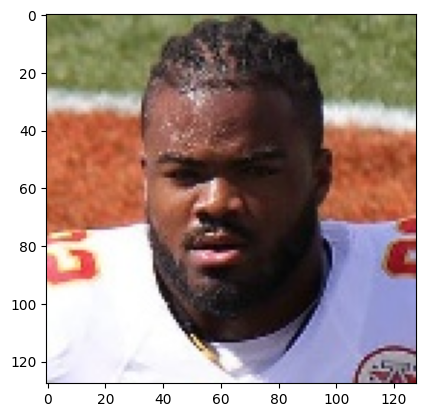

In [16]:
#show prediction for the picture of your choice
#filename is JUST and ONLY name of the file, don't put the path to the file you want to check
show_prediction(vis=vis, DATADIR=DATADIR, predictor=predictor, filename='_76.jpg')

In [5]:
#Grading sample is a sample of 1000 pictures randomly selected from our dataset to assess the accuracy of the model.
#We couldn't use normal techniques of assessing accuracy as our acceptable error rates were 3 and 8 years.
#This function assess the accuracy (and other parameteres) of the input image
#parameters are: actual age, predicted age, years difference, percentage years difference
def assess_grading_sample_accuracy(DATADIR, predictor, filename):
    actual_age = int(filename.split("_")[0])
    path = f"{DATADIR}/test/{actual_age}/{filename}"
    predicted_age = int(predictor.predict_filename(path)[0])
    
    diff = abs(actual_age-predicted_age)
    
    return [actual_age, predicted_age, diff, (diff/actual_age)*100]

In [5]:
def grading_sample_accuracy(DATADIR, grading_sample_path, predictor, amount=0) -> None:
    """assess accuracy based on the grading sample.
    Used to assess the accuracy and other parameters of the weight (predictor).

    Args:
        DATADIR (folder): folder with images of specific structure for ktrain
        grading_sample_path (path): path to the grading_sample.txt
        predictor (predictor): predictor object made by ktrain.get_predictor()
    """
    with open(grading_sample_path, "r") as f:
        gs = f.read().split(",")
        gs = gs[:-1]
        
    results = []
    for i, image in enumerate(gs):
        actual_age = int(image.split("_")[0])
        print(f"iteration {i+1}/{len(gs)} ({((i+1)/len(gs)*100):.2f}%) ETA: {((len(gs)-(i+1))*40/1000):.0f}s")
        path = f"{DATADIR}/test/{actual_age}/{image}"
        predicted_age = int(predictor.predict_filename(path)[0])

        diff = abs(actual_age-predicted_age)
        results.append([actual_age, predicted_age, diff, diff/actual_age])

    # Loop through each inner list and sum the second values
    avg_error = 0
    avg_perror = 0
    years3 = 0
    years8 = 0
    for age_diff in results:
        avg_error += age_diff[2]
        avg_perror += age_diff[3]
        if(age_diff[2] <= 3): years3 += 1
        if(age_diff[2] <= 8): years8 += 1
    avg_error /= len(gs)
    avg_perror /= len(gs)
    years3 /= len(gs)
    years8 /= len(gs)
    
    print(avg_error, "years(s)", f"{avg_perror:.2f}", "%", ", ± 3 years", f"{(years3*100):.2f}", "%, ± 8 years", f"{(years8*100):.2f}")
    return [avg_error, avg_perror, years3, years8]

In [7]:
#function used to get the weight which is later used to assess the accuracy
def get_weight(weightnumber):
    nums = []
    for file in os.listdir("Model_DL_ktrain_checkpoints\weights"):
        match = re.search(r'\d+', file)
        if match:
            number = int(match.group())
            nums.append(number)
    return f"weights-0{weightnumber}.hdf5" if weightnumber < 10 else f"weights-{weightnumber}.hdf5"

In [9]:
import os
import re

#this function goes thru the weights from [start] to [end] and assess their accuracies.
#This is the function we used to generate all the needed info for the grapphs.
#warning: it does not check if the weight exists. and it assumes that there are only 100 weights in the folder.
def assess_accuracy_with_weight(start=1, end=0):
    if start == 1:
        with open("weights_acc_assess.txt", 'w') as file:
            file.write("weight, avg_error, avg_perror, pm_3_years, pm_8_years")
    if(end==0): end=100
    for i in range(start,end+1,1):
        #load the weight
        model.load_weights(f"Model_DL_ktrain_checkpoints/weights/{get_weight(i)}")
        #make prediction of the grading sample
        print(f"MODEL WEIGHT {i}")
        res = grading_sample_accuracy(DATADIR, "grading_sample.txt", predictor) #model=predictor
        output = f"\n{i},{res[0]},{res[1]},{res[2]},{res[3]}"
        with open("weights_acc_assess.txt", 'a') as file:
            file.write(output)
    print("OPERATION COMPLETE. Check weightsDF for info.")
assess_accuracy_with_weight(1)

MODEL WEIGHT 94
iteration 1/1000 (0.10%) ETA: 40s
1/1 [==============================] - 0s 36ms/step
iteration 2/1000 (0.20%) ETA: 40s
1/1 [==============================] - 0s 37ms/step
iteration 3/1000 (0.30%) ETA: 40s
1/1 [==============================] - 0s 39ms/step
iteration 4/1000 (0.40%) ETA: 40s
1/1 [==============================] - 0s 39ms/step
iteration 5/1000 (0.50%) ETA: 40s
1/1 [==============================] - 0s 48ms/step
iteration 6/1000 (0.60%) ETA: 40s
1/1 [==============================] - 0s 41ms/step
iteration 7/1000 (0.70%) ETA: 40s
1/1 [==============================] - 0s 39ms/step
iteration 8/1000 (0.80%) ETA: 40s
1/1 [==============================] - 0s 41ms/step
iteration 9/1000 (0.90%) ETA: 40s
1/1 [==============================] - 0s 40ms/step
iteration 10/1000 (1.00%) ETA: 40s
1/1 [==============================] - 0s 37ms/step
iteration 11/1000 (1.10%) ETA: 40s
1/1 [==============================] - 0s 49ms/step
iteration 12/1000 (1.20%) ETA: 40s
1

1/1 [==============================] - 0s 55ms/step
iteration 96/1000 (9.60%) ETA: 36s
1/1 [==============================] - 0s 54ms/step
iteration 97/1000 (9.70%) ETA: 36s
1/1 [==============================] - 0s 44ms/step
iteration 98/1000 (9.80%) ETA: 36s
1/1 [==============================] - 0s 49ms/step
iteration 99/1000 (9.90%) ETA: 36s
1/1 [==============================] - 0s 51ms/step
iteration 100/1000 (10.00%) ETA: 36s
1/1 [==============================] - 0s 56ms/step
iteration 101/1000 (10.10%) ETA: 36s
1/1 [==============================] - 0s 43ms/step
iteration 102/1000 (10.20%) ETA: 36s
1/1 [==============================] - 0s 43ms/step
iteration 103/1000 (10.30%) ETA: 36s
1/1 [==============================] - 0s 58ms/step
iteration 104/1000 (10.40%) ETA: 36s
1/1 [==============================] - 0s 38ms/step
iteration 105/1000 (10.50%) ETA: 36s
1/1 [==============================] - 0s 40ms/step
iteration 106/1000 (10.60%) ETA: 36s
1/1 [========================

1/1 [==============================] - 0s 44ms/step
iteration 280/1000 (28.00%) ETA: 29s
1/1 [==============================] - 0s 47ms/step
iteration 281/1000 (28.10%) ETA: 29s
1/1 [==============================] - 0s 45ms/step
iteration 282/1000 (28.20%) ETA: 29s
1/1 [==============================] - 0s 52ms/step
iteration 283/1000 (28.30%) ETA: 29s
1/1 [==============================] - 0s 47ms/step
iteration 284/1000 (28.40%) ETA: 29s
1/1 [==============================] - 0s 45ms/step
iteration 285/1000 (28.50%) ETA: 29s
1/1 [==============================] - 0s 43ms/step
iteration 286/1000 (28.60%) ETA: 29s
1/1 [==============================] - 0s 44ms/step
iteration 287/1000 (28.70%) ETA: 29s
1/1 [==============================] - 0s 45ms/step
iteration 288/1000 (28.80%) ETA: 28s
1/1 [==============================] - 0s 45ms/step
iteration 289/1000 (28.90%) ETA: 28s
1/1 [==============================] - 0s 45ms/step
iteration 290/1000 (29.00%) ETA: 28s
1/1 [================

1/1 [==============================] - 0s 38ms/step
iteration 464/1000 (46.40%) ETA: 21s
1/1 [==============================] - 0s 38ms/step
iteration 465/1000 (46.50%) ETA: 21s
1/1 [==============================] - 0s 39ms/step
iteration 466/1000 (46.60%) ETA: 21s
1/1 [==============================] - 0s 39ms/step
iteration 467/1000 (46.70%) ETA: 21s
1/1 [==============================] - 0s 42ms/step
iteration 468/1000 (46.80%) ETA: 21s
1/1 [==============================] - 0s 40ms/step
iteration 469/1000 (46.90%) ETA: 21s
1/1 [==============================] - 0s 42ms/step
iteration 470/1000 (47.00%) ETA: 21s
1/1 [==============================] - 0s 38ms/step
iteration 471/1000 (47.10%) ETA: 21s
1/1 [==============================] - 0s 38ms/step
iteration 472/1000 (47.20%) ETA: 21s
1/1 [==============================] - 0s 39ms/step
iteration 473/1000 (47.30%) ETA: 21s
1/1 [==============================] - 0s 38ms/step
iteration 474/1000 (47.40%) ETA: 21s
1/1 [================

1/1 [==============================] - 0s 39ms/step
iteration 648/1000 (64.80%) ETA: 14s
1/1 [==============================] - 0s 39ms/step
iteration 649/1000 (64.90%) ETA: 14s
1/1 [==============================] - 0s 39ms/step
iteration 650/1000 (65.00%) ETA: 14s
1/1 [==============================] - 0s 38ms/step
iteration 651/1000 (65.10%) ETA: 14s
1/1 [==============================] - 0s 40ms/step
iteration 652/1000 (65.20%) ETA: 14s
1/1 [==============================] - 0s 38ms/step
iteration 653/1000 (65.30%) ETA: 14s
1/1 [==============================] - 0s 38ms/step
iteration 654/1000 (65.40%) ETA: 14s
1/1 [==============================] - 0s 41ms/step
iteration 655/1000 (65.50%) ETA: 14s
1/1 [==============================] - 0s 37ms/step
iteration 656/1000 (65.60%) ETA: 14s
1/1 [==============================] - 0s 38ms/step
iteration 657/1000 (65.70%) ETA: 14s
1/1 [==============================] - 0s 38ms/step
iteration 658/1000 (65.80%) ETA: 14s
1/1 [================

1/1 [==============================] - 0s 47ms/step
iteration 833/1000 (83.30%) ETA: 7s
1/1 [==============================] - 0s 42ms/step
iteration 834/1000 (83.40%) ETA: 7s
1/1 [==============================] - 0s 40ms/step
iteration 835/1000 (83.50%) ETA: 7s
1/1 [==============================] - 0s 41ms/step
iteration 836/1000 (83.60%) ETA: 7s
1/1 [==============================] - 0s 39ms/step
iteration 837/1000 (83.70%) ETA: 7s
1/1 [==============================] - 0s 84ms/step
iteration 838/1000 (83.80%) ETA: 6s
1/1 [==============================] - 0s 43ms/step
iteration 839/1000 (83.90%) ETA: 6s
1/1 [==============================] - 0s 40ms/step
iteration 840/1000 (84.00%) ETA: 6s
1/1 [==============================] - 0s 46ms/step
iteration 841/1000 (84.10%) ETA: 6s
1/1 [==============================] - 0s 46ms/step
iteration 842/1000 (84.20%) ETA: 6s
1/1 [==============================] - 0s 38ms/step
iteration 843/1000 (84.30%) ETA: 6s
1/1 [===========================

1/1 [==============================] - 0s 43ms/step
iteration 18/1000 (1.80%) ETA: 39s
1/1 [==============================] - 0s 49ms/step
iteration 19/1000 (1.90%) ETA: 39s
1/1 [==============================] - 0s 45ms/step
iteration 20/1000 (2.00%) ETA: 39s
1/1 [==============================] - 0s 39ms/step
iteration 21/1000 (2.10%) ETA: 39s
1/1 [==============================] - 0s 40ms/step
iteration 22/1000 (2.20%) ETA: 39s
1/1 [==============================] - 0s 42ms/step
iteration 23/1000 (2.30%) ETA: 39s
1/1 [==============================] - 0s 40ms/step
iteration 24/1000 (2.40%) ETA: 39s
1/1 [==============================] - 0s 46ms/step
iteration 25/1000 (2.50%) ETA: 39s
1/1 [==============================] - 0s 45ms/step
iteration 26/1000 (2.60%) ETA: 39s
1/1 [==============================] - 0s 41ms/step
iteration 27/1000 (2.70%) ETA: 39s
1/1 [==============================] - 0s 41ms/step
iteration 28/1000 (2.80%) ETA: 39s
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 41ms/step
iteration 112/1000 (11.20%) ETA: 36s
1/1 [==============================] - 0s 39ms/step
iteration 113/1000 (11.30%) ETA: 35s
1/1 [==============================] - 0s 41ms/step
iteration 114/1000 (11.40%) ETA: 35s
1/1 [==============================] - 0s 41ms/step
iteration 115/1000 (11.50%) ETA: 35s
1/1 [==============================] - 0s 39ms/step
iteration 116/1000 (11.60%) ETA: 35s
1/1 [==============================] - 0s 40ms/step
iteration 117/1000 (11.70%) ETA: 35s
1/1 [==============================] - 0s 40ms/step
iteration 118/1000 (11.80%) ETA: 35s
1/1 [==============================] - 0s 44ms/step
iteration 119/1000 (11.90%) ETA: 35s
1/1 [==============================] - 0s 41ms/step
iteration 120/1000 (12.00%) ETA: 35s
1/1 [==============================] - 0s 42ms/step
iteration 121/1000 (12.10%) ETA: 35s
1/1 [==============================] - 0s 41ms/step
iteration 122/1000 (12.20%) ETA: 35s
1/1 [================

1/1 [==============================] - 0s 41ms/step
iteration 296/1000 (29.60%) ETA: 28s
1/1 [==============================] - 0s 42ms/step
iteration 297/1000 (29.70%) ETA: 28s
1/1 [==============================] - 0s 44ms/step
iteration 298/1000 (29.80%) ETA: 28s
1/1 [==============================] - 0s 43ms/step
iteration 299/1000 (29.90%) ETA: 28s
1/1 [==============================] - 0s 40ms/step
iteration 300/1000 (30.00%) ETA: 28s
1/1 [==============================] - 0s 42ms/step
iteration 301/1000 (30.10%) ETA: 28s
1/1 [==============================] - 0s 40ms/step
iteration 302/1000 (30.20%) ETA: 28s
1/1 [==============================] - 0s 42ms/step
iteration 303/1000 (30.30%) ETA: 28s
1/1 [==============================] - 0s 41ms/step
iteration 304/1000 (30.40%) ETA: 28s
1/1 [==============================] - 0s 44ms/step
iteration 305/1000 (30.50%) ETA: 28s
1/1 [==============================] - 0s 46ms/step
iteration 306/1000 (30.60%) ETA: 28s
1/1 [================

1/1 [==============================] - 0s 38ms/step
iteration 480/1000 (48.00%) ETA: 21s
1/1 [==============================] - 0s 42ms/step
iteration 481/1000 (48.10%) ETA: 21s
1/1 [==============================] - 0s 42ms/step
iteration 482/1000 (48.20%) ETA: 21s
1/1 [==============================] - 0s 41ms/step
iteration 483/1000 (48.30%) ETA: 21s
1/1 [==============================] - 0s 45ms/step
iteration 484/1000 (48.40%) ETA: 21s
1/1 [==============================] - 0s 45ms/step
iteration 485/1000 (48.50%) ETA: 21s
1/1 [==============================] - 0s 41ms/step
iteration 486/1000 (48.60%) ETA: 21s
1/1 [==============================] - 0s 56ms/step
iteration 487/1000 (48.70%) ETA: 21s
1/1 [==============================] - 0s 41ms/step
iteration 488/1000 (48.80%) ETA: 20s
1/1 [==============================] - 0s 41ms/step
iteration 489/1000 (48.90%) ETA: 20s
1/1 [==============================] - 0s 43ms/step
iteration 490/1000 (49.00%) ETA: 20s
1/1 [================

1/1 [==============================] - 0s 43ms/step
iteration 664/1000 (66.40%) ETA: 13s
1/1 [==============================] - 0s 43ms/step
iteration 665/1000 (66.50%) ETA: 13s
1/1 [==============================] - 0s 38ms/step
iteration 666/1000 (66.60%) ETA: 13s
1/1 [==============================] - 0s 41ms/step
iteration 667/1000 (66.70%) ETA: 13s
1/1 [==============================] - 0s 39ms/step
iteration 668/1000 (66.80%) ETA: 13s
1/1 [==============================] - 0s 44ms/step
iteration 669/1000 (66.90%) ETA: 13s
1/1 [==============================] - 0s 40ms/step
iteration 670/1000 (67.00%) ETA: 13s
1/1 [==============================] - 0s 40ms/step
iteration 671/1000 (67.10%) ETA: 13s
1/1 [==============================] - 0s 40ms/step
iteration 672/1000 (67.20%) ETA: 13s
1/1 [==============================] - 0s 39ms/step
iteration 673/1000 (67.30%) ETA: 13s
1/1 [==============================] - 0s 44ms/step
iteration 674/1000 (67.40%) ETA: 13s
1/1 [================

1/1 [==============================] - 0s 42ms/step
iteration 849/1000 (84.90%) ETA: 6s
1/1 [==============================] - 0s 38ms/step
iteration 850/1000 (85.00%) ETA: 6s
1/1 [==============================] - 0s 40ms/step
iteration 851/1000 (85.10%) ETA: 6s
1/1 [==============================] - 0s 40ms/step
iteration 852/1000 (85.20%) ETA: 6s
1/1 [==============================] - 0s 40ms/step
iteration 853/1000 (85.30%) ETA: 6s
1/1 [==============================] - 0s 37ms/step
iteration 854/1000 (85.40%) ETA: 6s
1/1 [==============================] - 0s 39ms/step
iteration 855/1000 (85.50%) ETA: 6s
1/1 [==============================] - 0s 38ms/step
iteration 856/1000 (85.60%) ETA: 6s
1/1 [==============================] - 0s 40ms/step
iteration 857/1000 (85.70%) ETA: 6s
1/1 [==============================] - 0s 39ms/step
iteration 858/1000 (85.80%) ETA: 6s
1/1 [==============================] - 0s 40ms/step
iteration 859/1000 (85.90%) ETA: 6s
1/1 [===========================

1/1 [==============================] - 0s 38ms/step
iteration 35/1000 (3.50%) ETA: 39s
1/1 [==============================] - 0s 37ms/step
iteration 36/1000 (3.60%) ETA: 39s
1/1 [==============================] - 0s 41ms/step
iteration 37/1000 (3.70%) ETA: 39s
1/1 [==============================] - 0s 41ms/step
iteration 38/1000 (3.80%) ETA: 38s
1/1 [==============================] - 0s 38ms/step
iteration 39/1000 (3.90%) ETA: 38s
1/1 [==============================] - 0s 40ms/step
iteration 40/1000 (4.00%) ETA: 38s
1/1 [==============================] - 0s 37ms/step
iteration 41/1000 (4.10%) ETA: 38s
1/1 [==============================] - 0s 39ms/step
iteration 42/1000 (4.20%) ETA: 38s
1/1 [==============================] - 0s 39ms/step
iteration 43/1000 (4.30%) ETA: 38s
1/1 [==============================] - 0s 40ms/step
iteration 44/1000 (4.40%) ETA: 38s
1/1 [==============================] - 0s 42ms/step
iteration 45/1000 (4.50%) ETA: 38s
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 41ms/step
iteration 220/1000 (22.00%) ETA: 31s
1/1 [==============================] - 0s 41ms/step
iteration 221/1000 (22.10%) ETA: 31s
1/1 [==============================] - 0s 37ms/step
iteration 222/1000 (22.20%) ETA: 31s
1/1 [==============================] - 0s 40ms/step
iteration 223/1000 (22.30%) ETA: 31s
1/1 [==============================] - 0s 38ms/step
iteration 224/1000 (22.40%) ETA: 31s
1/1 [==============================] - 0s 38ms/step
iteration 225/1000 (22.50%) ETA: 31s
1/1 [==============================] - 0s 41ms/step
iteration 226/1000 (22.60%) ETA: 31s
1/1 [==============================] - 0s 39ms/step
iteration 227/1000 (22.70%) ETA: 31s
1/1 [==============================] - 0s 39ms/step
iteration 228/1000 (22.80%) ETA: 31s
1/1 [==============================] - 0s 38ms/step
iteration 229/1000 (22.90%) ETA: 31s
1/1 [==============================] - 0s 39ms/step
iteration 230/1000 (23.00%) ETA: 31s
1/1 [================

1/1 [==============================] - 0s 43ms/step
iteration 404/1000 (40.40%) ETA: 24s
1/1 [==============================] - 0s 49ms/step
iteration 405/1000 (40.50%) ETA: 24s
1/1 [==============================] - 0s 39ms/step
iteration 406/1000 (40.60%) ETA: 24s
1/1 [==============================] - 0s 39ms/step
iteration 407/1000 (40.70%) ETA: 24s
1/1 [==============================] - 0s 38ms/step
iteration 408/1000 (40.80%) ETA: 24s
1/1 [==============================] - 0s 41ms/step
iteration 409/1000 (40.90%) ETA: 24s
1/1 [==============================] - 0s 43ms/step
iteration 410/1000 (41.00%) ETA: 24s
1/1 [==============================] - 0s 38ms/step
iteration 411/1000 (41.10%) ETA: 24s
1/1 [==============================] - 0s 39ms/step
iteration 412/1000 (41.20%) ETA: 24s
1/1 [==============================] - 0s 41ms/step
iteration 413/1000 (41.30%) ETA: 23s
1/1 [==============================] - 0s 40ms/step
iteration 414/1000 (41.40%) ETA: 23s
1/1 [================

1/1 [==============================] - 0s 42ms/step
iteration 588/1000 (58.80%) ETA: 16s
1/1 [==============================] - 0s 40ms/step
iteration 589/1000 (58.90%) ETA: 16s
1/1 [==============================] - 0s 39ms/step
iteration 590/1000 (59.00%) ETA: 16s
1/1 [==============================] - 0s 42ms/step
iteration 591/1000 (59.10%) ETA: 16s
1/1 [==============================] - 0s 41ms/step
iteration 592/1000 (59.20%) ETA: 16s
1/1 [==============================] - 0s 39ms/step
iteration 593/1000 (59.30%) ETA: 16s
1/1 [==============================] - 0s 44ms/step
iteration 594/1000 (59.40%) ETA: 16s
1/1 [==============================] - 0s 40ms/step
iteration 595/1000 (59.50%) ETA: 16s
1/1 [==============================] - 0s 38ms/step
iteration 596/1000 (59.60%) ETA: 16s
1/1 [==============================] - 0s 45ms/step
iteration 597/1000 (59.70%) ETA: 16s
1/1 [==============================] - 0s 42ms/step
iteration 598/1000 (59.80%) ETA: 16s
1/1 [================

1/1 [==============================] - 0s 40ms/step
iteration 772/1000 (77.20%) ETA: 9s
1/1 [==============================] - 0s 40ms/step
iteration 773/1000 (77.30%) ETA: 9s
1/1 [==============================] - 0s 42ms/step
iteration 774/1000 (77.40%) ETA: 9s
1/1 [==============================] - 0s 41ms/step
iteration 775/1000 (77.50%) ETA: 9s
1/1 [==============================] - 0s 38ms/step
iteration 776/1000 (77.60%) ETA: 9s
1/1 [==============================] - 0s 40ms/step
iteration 777/1000 (77.70%) ETA: 9s
1/1 [==============================] - 0s 39ms/step
iteration 778/1000 (77.80%) ETA: 9s
1/1 [==============================] - 0s 40ms/step
iteration 779/1000 (77.90%) ETA: 9s
1/1 [==============================] - 0s 51ms/step
iteration 780/1000 (78.00%) ETA: 9s
1/1 [==============================] - 0s 38ms/step
iteration 781/1000 (78.10%) ETA: 9s
1/1 [==============================] - 0s 40ms/step
iteration 782/1000 (78.20%) ETA: 9s
1/1 [===========================

1/1 [==============================] - 0s 41ms/step
iteration 958/1000 (95.80%) ETA: 2s
1/1 [==============================] - 0s 39ms/step
iteration 959/1000 (95.90%) ETA: 2s
1/1 [==============================] - 0s 40ms/step
iteration 960/1000 (96.00%) ETA: 2s
1/1 [==============================] - 0s 40ms/step
iteration 961/1000 (96.10%) ETA: 2s
1/1 [==============================] - 0s 39ms/step
iteration 962/1000 (96.20%) ETA: 2s
1/1 [==============================] - 0s 39ms/step
iteration 963/1000 (96.30%) ETA: 1s
1/1 [==============================] - 0s 44ms/step
iteration 964/1000 (96.40%) ETA: 1s
1/1 [==============================] - 0s 42ms/step
iteration 965/1000 (96.50%) ETA: 1s
1/1 [==============================] - 0s 39ms/step
iteration 966/1000 (96.60%) ETA: 1s
1/1 [==============================] - 0s 39ms/step
iteration 967/1000 (96.70%) ETA: 1s
1/1 [==============================] - 0s 43ms/step
iteration 968/1000 (96.80%) ETA: 1s
1/1 [===========================

1/1 [==============================] - 0s 44ms/step
iteration 51/1000 (5.10%) ETA: 38s
1/1 [==============================] - 0s 47ms/step
iteration 52/1000 (5.20%) ETA: 38s
1/1 [==============================] - 0s 44ms/step
iteration 53/1000 (5.30%) ETA: 38s
1/1 [==============================] - 0s 46ms/step
iteration 54/1000 (5.40%) ETA: 38s
1/1 [==============================] - 0s 43ms/step
iteration 55/1000 (5.50%) ETA: 38s
1/1 [==============================] - 0s 47ms/step
iteration 56/1000 (5.60%) ETA: 38s
1/1 [==============================] - 0s 42ms/step
iteration 57/1000 (5.70%) ETA: 38s
1/1 [==============================] - 0s 55ms/step
iteration 58/1000 (5.80%) ETA: 38s
1/1 [==============================] - 0s 45ms/step
iteration 59/1000 (5.90%) ETA: 38s
1/1 [==============================] - 0s 45ms/step
iteration 60/1000 (6.00%) ETA: 38s
1/1 [==============================] - 0s 45ms/step
iteration 61/1000 (6.10%) ETA: 38s
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 43ms/step
iteration 236/1000 (23.60%) ETA: 31s
1/1 [==============================] - 0s 41ms/step
iteration 237/1000 (23.70%) ETA: 31s
1/1 [==============================] - 0s 46ms/step
iteration 238/1000 (23.80%) ETA: 30s
1/1 [==============================] - 0s 43ms/step
iteration 239/1000 (23.90%) ETA: 30s
1/1 [==============================] - 0s 41ms/step
iteration 240/1000 (24.00%) ETA: 30s
1/1 [==============================] - 0s 50ms/step
iteration 241/1000 (24.10%) ETA: 30s
1/1 [==============================] - 0s 42ms/step
iteration 242/1000 (24.20%) ETA: 30s
1/1 [==============================] - 0s 39ms/step
iteration 243/1000 (24.30%) ETA: 30s
1/1 [==============================] - 0s 39ms/step
iteration 244/1000 (24.40%) ETA: 30s
1/1 [==============================] - 0s 43ms/step
iteration 245/1000 (24.50%) ETA: 30s
1/1 [==============================] - 0s 39ms/step
iteration 246/1000 (24.60%) ETA: 30s
1/1 [================

1/1 [==============================] - 0s 40ms/step
iteration 420/1000 (42.00%) ETA: 23s
1/1 [==============================] - 0s 41ms/step
iteration 421/1000 (42.10%) ETA: 23s
1/1 [==============================] - 0s 43ms/step
iteration 422/1000 (42.20%) ETA: 23s
1/1 [==============================] - 0s 38ms/step
iteration 423/1000 (42.30%) ETA: 23s
1/1 [==============================] - 0s 41ms/step
iteration 424/1000 (42.40%) ETA: 23s
1/1 [==============================] - 0s 39ms/step
iteration 425/1000 (42.50%) ETA: 23s
1/1 [==============================] - 0s 40ms/step
iteration 426/1000 (42.60%) ETA: 23s
1/1 [==============================] - 0s 39ms/step
iteration 427/1000 (42.70%) ETA: 23s
1/1 [==============================] - 0s 43ms/step
iteration 428/1000 (42.80%) ETA: 23s
1/1 [==============================] - 0s 42ms/step
iteration 429/1000 (42.90%) ETA: 23s
1/1 [==============================] - 0s 39ms/step
iteration 430/1000 (43.00%) ETA: 23s
1/1 [================

1/1 [==============================] - 0s 42ms/step
iteration 604/1000 (60.40%) ETA: 16s
1/1 [==============================] - 0s 42ms/step
iteration 605/1000 (60.50%) ETA: 16s
1/1 [==============================] - 0s 45ms/step
iteration 606/1000 (60.60%) ETA: 16s
1/1 [==============================] - 0s 44ms/step
iteration 607/1000 (60.70%) ETA: 16s
1/1 [==============================] - 0s 42ms/step
iteration 608/1000 (60.80%) ETA: 16s
1/1 [==============================] - 0s 39ms/step
iteration 609/1000 (60.90%) ETA: 16s
1/1 [==============================] - 0s 41ms/step
iteration 610/1000 (61.00%) ETA: 16s
1/1 [==============================] - 0s 46ms/step
iteration 611/1000 (61.10%) ETA: 16s
1/1 [==============================] - 0s 39ms/step
iteration 612/1000 (61.20%) ETA: 16s
1/1 [==============================] - 0s 41ms/step
iteration 613/1000 (61.30%) ETA: 15s
1/1 [==============================] - 0s 42ms/step
iteration 614/1000 (61.40%) ETA: 15s
1/1 [================

1/1 [==============================] - 0s 42ms/step
iteration 788/1000 (78.80%) ETA: 8s
1/1 [==============================] - 0s 40ms/step
iteration 789/1000 (78.90%) ETA: 8s
1/1 [==============================] - 0s 45ms/step
iteration 790/1000 (79.00%) ETA: 8s
1/1 [==============================] - 0s 43ms/step
iteration 791/1000 (79.10%) ETA: 8s
1/1 [==============================] - 0s 39ms/step
iteration 792/1000 (79.20%) ETA: 8s
1/1 [==============================] - 0s 40ms/step
iteration 793/1000 (79.30%) ETA: 8s
1/1 [==============================] - 0s 44ms/step
iteration 794/1000 (79.40%) ETA: 8s
1/1 [==============================] - 0s 39ms/step
iteration 795/1000 (79.50%) ETA: 8s
1/1 [==============================] - 0s 42ms/step
iteration 796/1000 (79.60%) ETA: 8s
1/1 [==============================] - 0s 39ms/step
iteration 797/1000 (79.70%) ETA: 8s
1/1 [==============================] - 0s 39ms/step
iteration 798/1000 (79.80%) ETA: 8s
1/1 [===========================

1/1 [==============================] - 0s 42ms/step
iteration 974/1000 (97.40%) ETA: 1s
1/1 [==============================] - 0s 44ms/step
iteration 975/1000 (97.50%) ETA: 1s
1/1 [==============================] - 0s 39ms/step
iteration 976/1000 (97.60%) ETA: 1s
1/1 [==============================] - 0s 42ms/step
iteration 977/1000 (97.70%) ETA: 1s
1/1 [==============================] - 0s 41ms/step
iteration 978/1000 (97.80%) ETA: 1s
1/1 [==============================] - 0s 42ms/step
iteration 979/1000 (97.90%) ETA: 1s
1/1 [==============================] - 0s 40ms/step
iteration 980/1000 (98.00%) ETA: 1s
1/1 [==============================] - 0s 41ms/step
iteration 981/1000 (98.10%) ETA: 1s
1/1 [==============================] - 0s 40ms/step
iteration 982/1000 (98.20%) ETA: 1s
1/1 [==============================] - 0s 39ms/step
iteration 983/1000 (98.30%) ETA: 1s
1/1 [==============================] - 0s 41ms/step
iteration 984/1000 (98.40%) ETA: 1s
1/1 [===========================

1/1 [==============================] - 0s 40ms/step
iteration 160/1000 (16.00%) ETA: 34s
1/1 [==============================] - 0s 51ms/step
iteration 161/1000 (16.10%) ETA: 34s
1/1 [==============================] - 0s 45ms/step
iteration 162/1000 (16.20%) ETA: 34s
1/1 [==============================] - 0s 39ms/step
iteration 163/1000 (16.30%) ETA: 33s
1/1 [==============================] - 0s 42ms/step
iteration 164/1000 (16.40%) ETA: 33s
1/1 [==============================] - 0s 43ms/step
iteration 165/1000 (16.50%) ETA: 33s
1/1 [==============================] - 0s 49ms/step
iteration 166/1000 (16.60%) ETA: 33s
1/1 [==============================] - 0s 46ms/step
iteration 167/1000 (16.70%) ETA: 33s
1/1 [==============================] - 0s 47ms/step
iteration 168/1000 (16.80%) ETA: 33s
1/1 [==============================] - 0s 49ms/step
iteration 169/1000 (16.90%) ETA: 33s
1/1 [==============================] - 0s 42ms/step
iteration 170/1000 (17.00%) ETA: 33s
1/1 [================

1/1 [==============================] - 0s 41ms/step
iteration 344/1000 (34.40%) ETA: 26s
1/1 [==============================] - 0s 47ms/step
iteration 345/1000 (34.50%) ETA: 26s
1/1 [==============================] - 0s 40ms/step
iteration 346/1000 (34.60%) ETA: 26s
1/1 [==============================] - 0s 48ms/step
iteration 347/1000 (34.70%) ETA: 26s
1/1 [==============================] - 0s 46ms/step
iteration 348/1000 (34.80%) ETA: 26s
1/1 [==============================] - 0s 42ms/step
iteration 349/1000 (34.90%) ETA: 26s
1/1 [==============================] - 0s 45ms/step
iteration 350/1000 (35.00%) ETA: 26s
1/1 [==============================] - 0s 44ms/step
iteration 351/1000 (35.10%) ETA: 26s
1/1 [==============================] - 0s 55ms/step
iteration 352/1000 (35.20%) ETA: 26s
1/1 [==============================] - 0s 44ms/step
iteration 353/1000 (35.30%) ETA: 26s
1/1 [==============================] - 0s 46ms/step
iteration 354/1000 (35.40%) ETA: 26s
1/1 [================

1/1 [==============================] - 0s 47ms/step
iteration 528/1000 (52.80%) ETA: 19s
1/1 [==============================] - 0s 45ms/step
iteration 529/1000 (52.90%) ETA: 19s
1/1 [==============================] - 0s 42ms/step
iteration 530/1000 (53.00%) ETA: 19s
1/1 [==============================] - 0s 41ms/step
iteration 531/1000 (53.10%) ETA: 19s
1/1 [==============================] - 0s 43ms/step
iteration 532/1000 (53.20%) ETA: 19s
1/1 [==============================] - 0s 41ms/step
iteration 533/1000 (53.30%) ETA: 19s
1/1 [==============================] - 0s 40ms/step
iteration 534/1000 (53.40%) ETA: 19s
1/1 [==============================] - 0s 45ms/step
iteration 535/1000 (53.50%) ETA: 19s
1/1 [==============================] - 0s 40ms/step
iteration 536/1000 (53.60%) ETA: 19s
1/1 [==============================] - 0s 50ms/step
iteration 537/1000 (53.70%) ETA: 19s
1/1 [==============================] - 0s 44ms/step
iteration 538/1000 (53.80%) ETA: 18s
1/1 [================

1/1 [==============================] - 0s 51ms/step
iteration 712/1000 (71.20%) ETA: 12s
1/1 [==============================] - 0s 58ms/step
iteration 713/1000 (71.30%) ETA: 11s
1/1 [==============================] - 0s 41ms/step
iteration 714/1000 (71.40%) ETA: 11s
1/1 [==============================] - 0s 49ms/step
iteration 715/1000 (71.50%) ETA: 11s
1/1 [==============================] - 0s 42ms/step
iteration 716/1000 (71.60%) ETA: 11s
1/1 [==============================] - 0s 46ms/step
iteration 717/1000 (71.70%) ETA: 11s
1/1 [==============================] - 0s 42ms/step
iteration 718/1000 (71.80%) ETA: 11s
1/1 [==============================] - 0s 45ms/step
iteration 719/1000 (71.90%) ETA: 11s
1/1 [==============================] - 0s 43ms/step
iteration 720/1000 (72.00%) ETA: 11s
1/1 [==============================] - 0s 50ms/step
iteration 721/1000 (72.10%) ETA: 11s
1/1 [==============================] - 0s 46ms/step
iteration 722/1000 (72.20%) ETA: 11s
1/1 [================

1/1 [==============================] - 0s 46ms/step
iteration 897/1000 (89.70%) ETA: 4s
1/1 [==============================] - 0s 43ms/step
iteration 898/1000 (89.80%) ETA: 4s
1/1 [==============================] - 0s 48ms/step
iteration 899/1000 (89.90%) ETA: 4s
1/1 [==============================] - 0s 43ms/step
iteration 900/1000 (90.00%) ETA: 4s
1/1 [==============================] - 0s 47ms/step
iteration 901/1000 (90.10%) ETA: 4s
1/1 [==============================] - 0s 44ms/step
iteration 902/1000 (90.20%) ETA: 4s
1/1 [==============================] - 0s 43ms/step
iteration 903/1000 (90.30%) ETA: 4s
1/1 [==============================] - 0s 42ms/step
iteration 904/1000 (90.40%) ETA: 4s
1/1 [==============================] - 0s 44ms/step
iteration 905/1000 (90.50%) ETA: 4s
1/1 [==============================] - 0s 46ms/step
iteration 906/1000 (90.60%) ETA: 4s
1/1 [==============================] - 0s 44ms/step
iteration 907/1000 (90.70%) ETA: 4s
1/1 [===========================

1/1 [==============================] - 0s 45ms/step
iteration 83/1000 (8.30%) ETA: 37s
1/1 [==============================] - 0s 45ms/step
iteration 84/1000 (8.40%) ETA: 37s
1/1 [==============================] - 0s 44ms/step
iteration 85/1000 (8.50%) ETA: 37s
1/1 [==============================] - 0s 46ms/step
iteration 86/1000 (8.60%) ETA: 37s
1/1 [==============================] - 0s 46ms/step
iteration 87/1000 (8.70%) ETA: 37s
1/1 [==============================] - 0s 42ms/step
iteration 88/1000 (8.80%) ETA: 36s
1/1 [==============================] - 0s 44ms/step
iteration 89/1000 (8.90%) ETA: 36s
1/1 [==============================] - 0s 45ms/step
iteration 90/1000 (9.00%) ETA: 36s
1/1 [==============================] - 0s 42ms/step
iteration 91/1000 (9.10%) ETA: 36s
1/1 [==============================] - 0s 44ms/step
iteration 92/1000 (9.20%) ETA: 36s
1/1 [==============================] - 0s 44ms/step
iteration 93/1000 (9.30%) ETA: 36s
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 60ms/step
iteration 267/1000 (26.70%) ETA: 29s
1/1 [==============================] - 0s 45ms/step
iteration 268/1000 (26.80%) ETA: 29s
1/1 [==============================] - 0s 47ms/step
iteration 269/1000 (26.90%) ETA: 29s
1/1 [==============================] - 0s 47ms/step
iteration 270/1000 (27.00%) ETA: 29s
1/1 [==============================] - 0s 45ms/step
iteration 271/1000 (27.10%) ETA: 29s
1/1 [==============================] - 0s 43ms/step
iteration 272/1000 (27.20%) ETA: 29s
1/1 [==============================] - 0s 50ms/step
iteration 273/1000 (27.30%) ETA: 29s
1/1 [==============================] - 0s 46ms/step
iteration 274/1000 (27.40%) ETA: 29s
1/1 [==============================] - 0s 43ms/step
iteration 275/1000 (27.50%) ETA: 29s
1/1 [==============================] - 0s 50ms/step
iteration 276/1000 (27.60%) ETA: 29s
1/1 [==============================] - 0s 49ms/step
iteration 277/1000 (27.70%) ETA: 29s
1/1 [================

1/1 [==============================] - 0s 43ms/step
iteration 451/1000 (45.10%) ETA: 22s
1/1 [==============================] - 0s 46ms/step
iteration 452/1000 (45.20%) ETA: 22s
1/1 [==============================] - 0s 43ms/step
iteration 453/1000 (45.30%) ETA: 22s
1/1 [==============================] - 0s 43ms/step
iteration 454/1000 (45.40%) ETA: 22s
1/1 [==============================] - 0s 44ms/step
iteration 455/1000 (45.50%) ETA: 22s
1/1 [==============================] - 0s 48ms/step
iteration 456/1000 (45.60%) ETA: 22s
1/1 [==============================] - 0s 47ms/step
iteration 457/1000 (45.70%) ETA: 22s
1/1 [==============================] - 0s 47ms/step
iteration 458/1000 (45.80%) ETA: 22s
1/1 [==============================] - 0s 41ms/step
iteration 459/1000 (45.90%) ETA: 22s
1/1 [==============================] - 0s 46ms/step
iteration 460/1000 (46.00%) ETA: 22s
1/1 [==============================] - 0s 47ms/step
iteration 461/1000 (46.10%) ETA: 22s
1/1 [================

1/1 [==============================] - 0s 47ms/step
iteration 635/1000 (63.50%) ETA: 15s
1/1 [==============================] - 0s 45ms/step
iteration 636/1000 (63.60%) ETA: 15s
1/1 [==============================] - 0s 41ms/step
iteration 637/1000 (63.70%) ETA: 15s
1/1 [==============================] - 0s 45ms/step
iteration 638/1000 (63.80%) ETA: 14s
1/1 [==============================] - 0s 43ms/step
iteration 639/1000 (63.90%) ETA: 14s
1/1 [==============================] - 0s 45ms/step
iteration 640/1000 (64.00%) ETA: 14s
1/1 [==============================] - 0s 42ms/step
iteration 641/1000 (64.10%) ETA: 14s
1/1 [==============================] - 0s 45ms/step
iteration 642/1000 (64.20%) ETA: 14s
1/1 [==============================] - 0s 48ms/step
iteration 643/1000 (64.30%) ETA: 14s
1/1 [==============================] - 0s 43ms/step
iteration 644/1000 (64.40%) ETA: 14s
1/1 [==============================] - 0s 46ms/step
iteration 645/1000 (64.50%) ETA: 14s
1/1 [================

1/1 [==============================] - 0s 44ms/step
iteration 820/1000 (82.00%) ETA: 7s
1/1 [==============================] - 0s 48ms/step
iteration 821/1000 (82.10%) ETA: 7s
1/1 [==============================] - 0s 43ms/step
iteration 822/1000 (82.20%) ETA: 7s
1/1 [==============================] - 0s 40ms/step
iteration 823/1000 (82.30%) ETA: 7s
1/1 [==============================] - 0s 45ms/step
iteration 824/1000 (82.40%) ETA: 7s
1/1 [==============================] - 0s 47ms/step
iteration 825/1000 (82.50%) ETA: 7s
1/1 [==============================] - 0s 49ms/step
iteration 826/1000 (82.60%) ETA: 7s
1/1 [==============================] - 0s 43ms/step
iteration 827/1000 (82.70%) ETA: 7s
1/1 [==============================] - 0s 42ms/step
iteration 828/1000 (82.80%) ETA: 7s
1/1 [==============================] - 0s 44ms/step
iteration 829/1000 (82.90%) ETA: 7s
1/1 [==============================] - 0s 41ms/step
iteration 830/1000 (83.00%) ETA: 7s
1/1 [===========================

1/1 [==============================] - 0s 44ms/step
iteration 5/1000 (0.50%) ETA: 40s
1/1 [==============================] - 0s 54ms/step
iteration 6/1000 (0.60%) ETA: 40s
1/1 [==============================] - 0s 48ms/step
iteration 7/1000 (0.70%) ETA: 40s
1/1 [==============================] - 0s 56ms/step
iteration 8/1000 (0.80%) ETA: 40s
1/1 [==============================] - 0s 48ms/step
iteration 9/1000 (0.90%) ETA: 40s
1/1 [==============================] - 0s 44ms/step
iteration 10/1000 (1.00%) ETA: 40s
1/1 [==============================] - 0s 45ms/step
iteration 11/1000 (1.10%) ETA: 40s
1/1 [==============================] - 0s 46ms/step
iteration 12/1000 (1.20%) ETA: 40s
1/1 [==============================] - 0s 45ms/step
iteration 13/1000 (1.30%) ETA: 39s
1/1 [==============================] - 0s 52ms/step
iteration 14/1000 (1.40%) ETA: 39s
1/1 [==============================] - 0s 42ms/step
iteration 15/1000 (1.50%) ETA: 39s
1/1 [==============================] - 0s 43ms/s

1/1 [==============================] - 0s 45ms/step
iteration 191/1000 (19.10%) ETA: 32s
1/1 [==============================] - 0s 47ms/step
iteration 192/1000 (19.20%) ETA: 32s
1/1 [==============================] - 0s 42ms/step
iteration 193/1000 (19.30%) ETA: 32s
1/1 [==============================] - 0s 47ms/step
iteration 194/1000 (19.40%) ETA: 32s
1/1 [==============================] - 0s 44ms/step
iteration 195/1000 (19.50%) ETA: 32s
1/1 [==============================] - 0s 45ms/step
iteration 196/1000 (19.60%) ETA: 32s
1/1 [==============================] - 0s 45ms/step
iteration 197/1000 (19.70%) ETA: 32s
1/1 [==============================] - 0s 47ms/step
iteration 198/1000 (19.80%) ETA: 32s
1/1 [==============================] - 0s 42ms/step
iteration 199/1000 (19.90%) ETA: 32s
1/1 [==============================] - 0s 46ms/step
iteration 200/1000 (20.00%) ETA: 32s
1/1 [==============================] - 0s 48ms/step
iteration 201/1000 (20.10%) ETA: 32s
1/1 [================

1/1 [==============================] - 0s 48ms/step
iteration 375/1000 (37.50%) ETA: 25s
1/1 [==============================] - 0s 43ms/step
iteration 376/1000 (37.60%) ETA: 25s
1/1 [==============================] - 0s 51ms/step
iteration 377/1000 (37.70%) ETA: 25s
1/1 [==============================] - 0s 51ms/step
iteration 378/1000 (37.80%) ETA: 25s
1/1 [==============================] - 0s 50ms/step
iteration 379/1000 (37.90%) ETA: 25s
1/1 [==============================] - 0s 95ms/step
iteration 380/1000 (38.00%) ETA: 25s
1/1 [==============================] - 0s 46ms/step
iteration 381/1000 (38.10%) ETA: 25s
1/1 [==============================] - 0s 50ms/step
iteration 382/1000 (38.20%) ETA: 25s
1/1 [==============================] - 0s 55ms/step
iteration 383/1000 (38.30%) ETA: 25s
1/1 [==============================] - 0s 50ms/step
iteration 384/1000 (38.40%) ETA: 25s
1/1 [==============================] - 0s 50ms/step
iteration 385/1000 (38.50%) ETA: 25s
1/1 [================

1/1 [==============================] - 0s 46ms/step
iteration 559/1000 (55.90%) ETA: 18s
1/1 [==============================] - 0s 48ms/step
iteration 560/1000 (56.00%) ETA: 18s
1/1 [==============================] - 0s 47ms/step
iteration 561/1000 (56.10%) ETA: 18s
1/1 [==============================] - 0s 46ms/step
iteration 562/1000 (56.20%) ETA: 18s
1/1 [==============================] - 0s 42ms/step
iteration 563/1000 (56.30%) ETA: 17s
1/1 [==============================] - 0s 45ms/step
iteration 564/1000 (56.40%) ETA: 17s
1/1 [==============================] - 0s 49ms/step
iteration 565/1000 (56.50%) ETA: 17s
1/1 [==============================] - 0s 42ms/step
iteration 566/1000 (56.60%) ETA: 17s
1/1 [==============================] - 0s 41ms/step
iteration 567/1000 (56.70%) ETA: 17s
1/1 [==============================] - 0s 45ms/step
iteration 568/1000 (56.80%) ETA: 17s
1/1 [==============================] - 0s 43ms/step
iteration 569/1000 (56.90%) ETA: 17s
1/1 [================

1/1 [==============================] - 0s 42ms/step
iteration 743/1000 (74.30%) ETA: 10s
1/1 [==============================] - 0s 42ms/step
iteration 744/1000 (74.40%) ETA: 10s
1/1 [==============================] - 0s 44ms/step
iteration 745/1000 (74.50%) ETA: 10s
1/1 [==============================] - 0s 47ms/step
iteration 746/1000 (74.60%) ETA: 10s
1/1 [==============================] - 0s 43ms/step
iteration 747/1000 (74.70%) ETA: 10s
1/1 [==============================] - 0s 49ms/step
iteration 748/1000 (74.80%) ETA: 10s
1/1 [==============================] - 0s 44ms/step
iteration 749/1000 (74.90%) ETA: 10s
1/1 [==============================] - 0s 43ms/step
iteration 750/1000 (75.00%) ETA: 10s
1/1 [==============================] - 0s 45ms/step
iteration 751/1000 (75.10%) ETA: 10s
1/1 [==============================] - 0s 64ms/step
iteration 752/1000 (75.20%) ETA: 10s
1/1 [==============================] - 0s 58ms/step
iteration 753/1000 (75.30%) ETA: 10s
1/1 [================

1/1 [==============================] - 0s 39ms/step
iteration 836/1000 (83.60%) ETA: 7s
1/1 [==============================] - 0s 40ms/step
iteration 837/1000 (83.70%) ETA: 7s
1/1 [==============================] - 0s 42ms/step
iteration 838/1000 (83.80%) ETA: 6s
1/1 [==============================] - 0s 46ms/step
iteration 839/1000 (83.90%) ETA: 6s
1/1 [==============================] - 0s 41ms/step
iteration 840/1000 (84.00%) ETA: 6s
1/1 [==============================] - 0s 44ms/step
iteration 841/1000 (84.10%) ETA: 6s
1/1 [==============================] - 0s 42ms/step
iteration 842/1000 (84.20%) ETA: 6s
1/1 [==============================] - 0s 42ms/step
iteration 843/1000 (84.30%) ETA: 6s
1/1 [==============================] - 0s 41ms/step
iteration 844/1000 (84.40%) ETA: 6s
1/1 [==============================] - 0s 44ms/step
iteration 845/1000 (84.50%) ETA: 6s
1/1 [==============================] - 0s 43ms/step
iteration 846/1000 (84.60%) ETA: 6s
1/1 [===========================